In [8]:
#!pip install pandas
#!pip install numpy
import numpy as np
import pandas as pd
import os
for dirname,_, filenames in os.walk('/home/vishu/Documents/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

/home/vishu/Documents/kaggle/input/test.csv
/home/vishu/Documents/kaggle/input/sample_submission.csv
/home/vishu/Documents/kaggle/input/train.csv


# Importing necessary Libraries

In [9]:
#!pip install matplotlib
#!pip install seaborn
#!pip install wordcloud
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
#!pip install spacy
#!pip install sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict
import spacy
import en_core_web_sm
import nltk
nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('average_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
stop=set(stopwords.words('english'))


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Core packages for general use throughout the notebook.
import warnings
import time
import datetime
import re
import string

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Setting some options for general use.
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.25)
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vishu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load Data

In [10]:
train=pd.read_csv('/home/vishu/Documents/kaggle/input/train.csv')
test=pd.read_csv('/home/vishu/Documents/kaggle/input/test.csv')
sub=pd.read_csv('/home/vishu/Documents/kaggle/input/sample_submission.csv')

In [11]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [12]:
display(train.sample(10))

,id,keyword,location,text,target
3819,5428,first%20responders,New York City,I just added 'Sandy First Responders Lost Thei...,1
5791,8262,rioting,tri state,#BHRAMABULL Watch Run The Jewels Use Facts to ...,1
6935,9945,trouble,North Carolina,@TJ_Robertson2 no bc we always got in trouble ...,0
226,321,annihilated,the own zone layer,day 1 of tryouts went good minus the fact I st...,0
6506,9301,survive,NaN,So much shit has happened today wtf idk how I ...,1
30,44,NaN,NaN,The end!,0
2358,3394,demolition,US-PR,@Treyarch @DavidVonderhaar bring back demolit...,0
4542,6458,injured,london,Udhampur terror attack: Militants attack polic...,1
6571,9404,survivors,"Chicago, IL",RT @kotowsa: South SudanÛªs war on women: sur...,1
1294,1869,burned,NaN,Just burned the shit outta myself on my dirt b...,0


In [13]:
display(test.sample(10))

,id,keyword,location,text
1828,6179,hijack,Lagos,Bayelsa poll: Plans by Patience Jonathan to hi...
2928,9693,tornado,"riverwest, milw",@dead_last I'm going to live out of my car for...
2648,8847,smoke,NaN,just trying to smoke and get Taco Bell
135,428,apocalypse,NaN,Also my other nephew is proof that fat babies ...
1201,3943,devastated,NaN,Absolutely devastated ???? no Ross no!! #Emmer...
1385,4566,emergency%20plan,"Houston, Texas",Emergency-response plan helps employees get ba...
999,3298,demolish,NaN,I promise you @WinningWhit and I could assembl...
1162,3843,detonate,"Nashville, TN",@someone92883220 they had to detonate it to de...
1582,5348,fire,Lakeland Fl,@traplordthings Y din u fav my fire memez åÀ!
2135,7145,mudslide,Merseyside,@AlexxPage cried at the mudslide cake ??


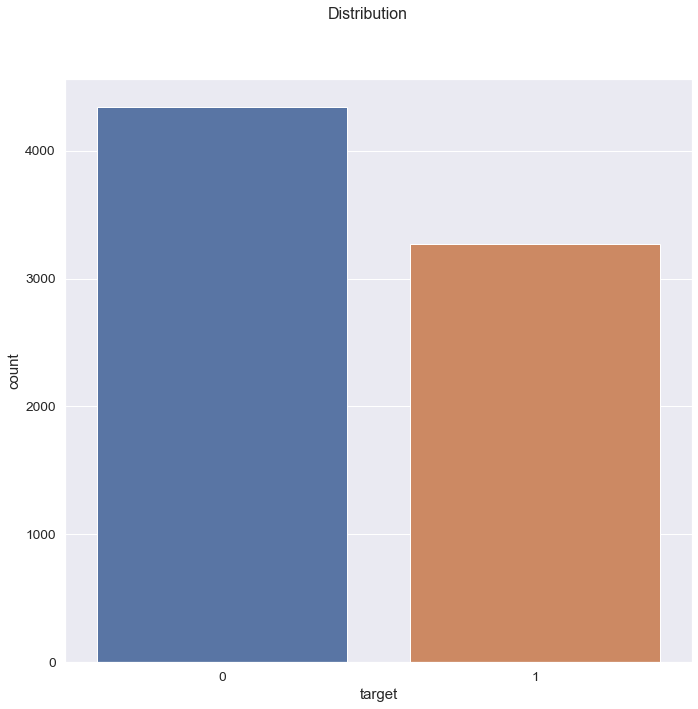

In [14]:
fig, axes= plt.subplots(ncols=1, nrows=1 , figsize=(10,10))
sns.countplot(train['target'])
plt.suptitle('Distribution',fontsize=16)
plt.show()

## Meta Features


With the help of meta features we can figure out the difference between diaster and non disaster tweets.

Some of the meta features are:

<li>word_count: number of words in text
<li>unique_word_count: number of unique words in text
<li>stopword_count: number of stop words in text
<li>url_count number: of urls in text
<li>mean_word_length: average character count in words
<li>char_count number: of characters in text
<li>punctuation_count: number of punctuations in text
<li>hashtag_count: number of hashtags (#) in text
<li>mention_count: number of mentions (@) in text

In [15]:
# total word count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# total unique word count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stopwords count
train['stopword_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stopword_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#url_count
train['url_count']=train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count']=test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

#mean word length
train['mean_word_length']= train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length']= test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

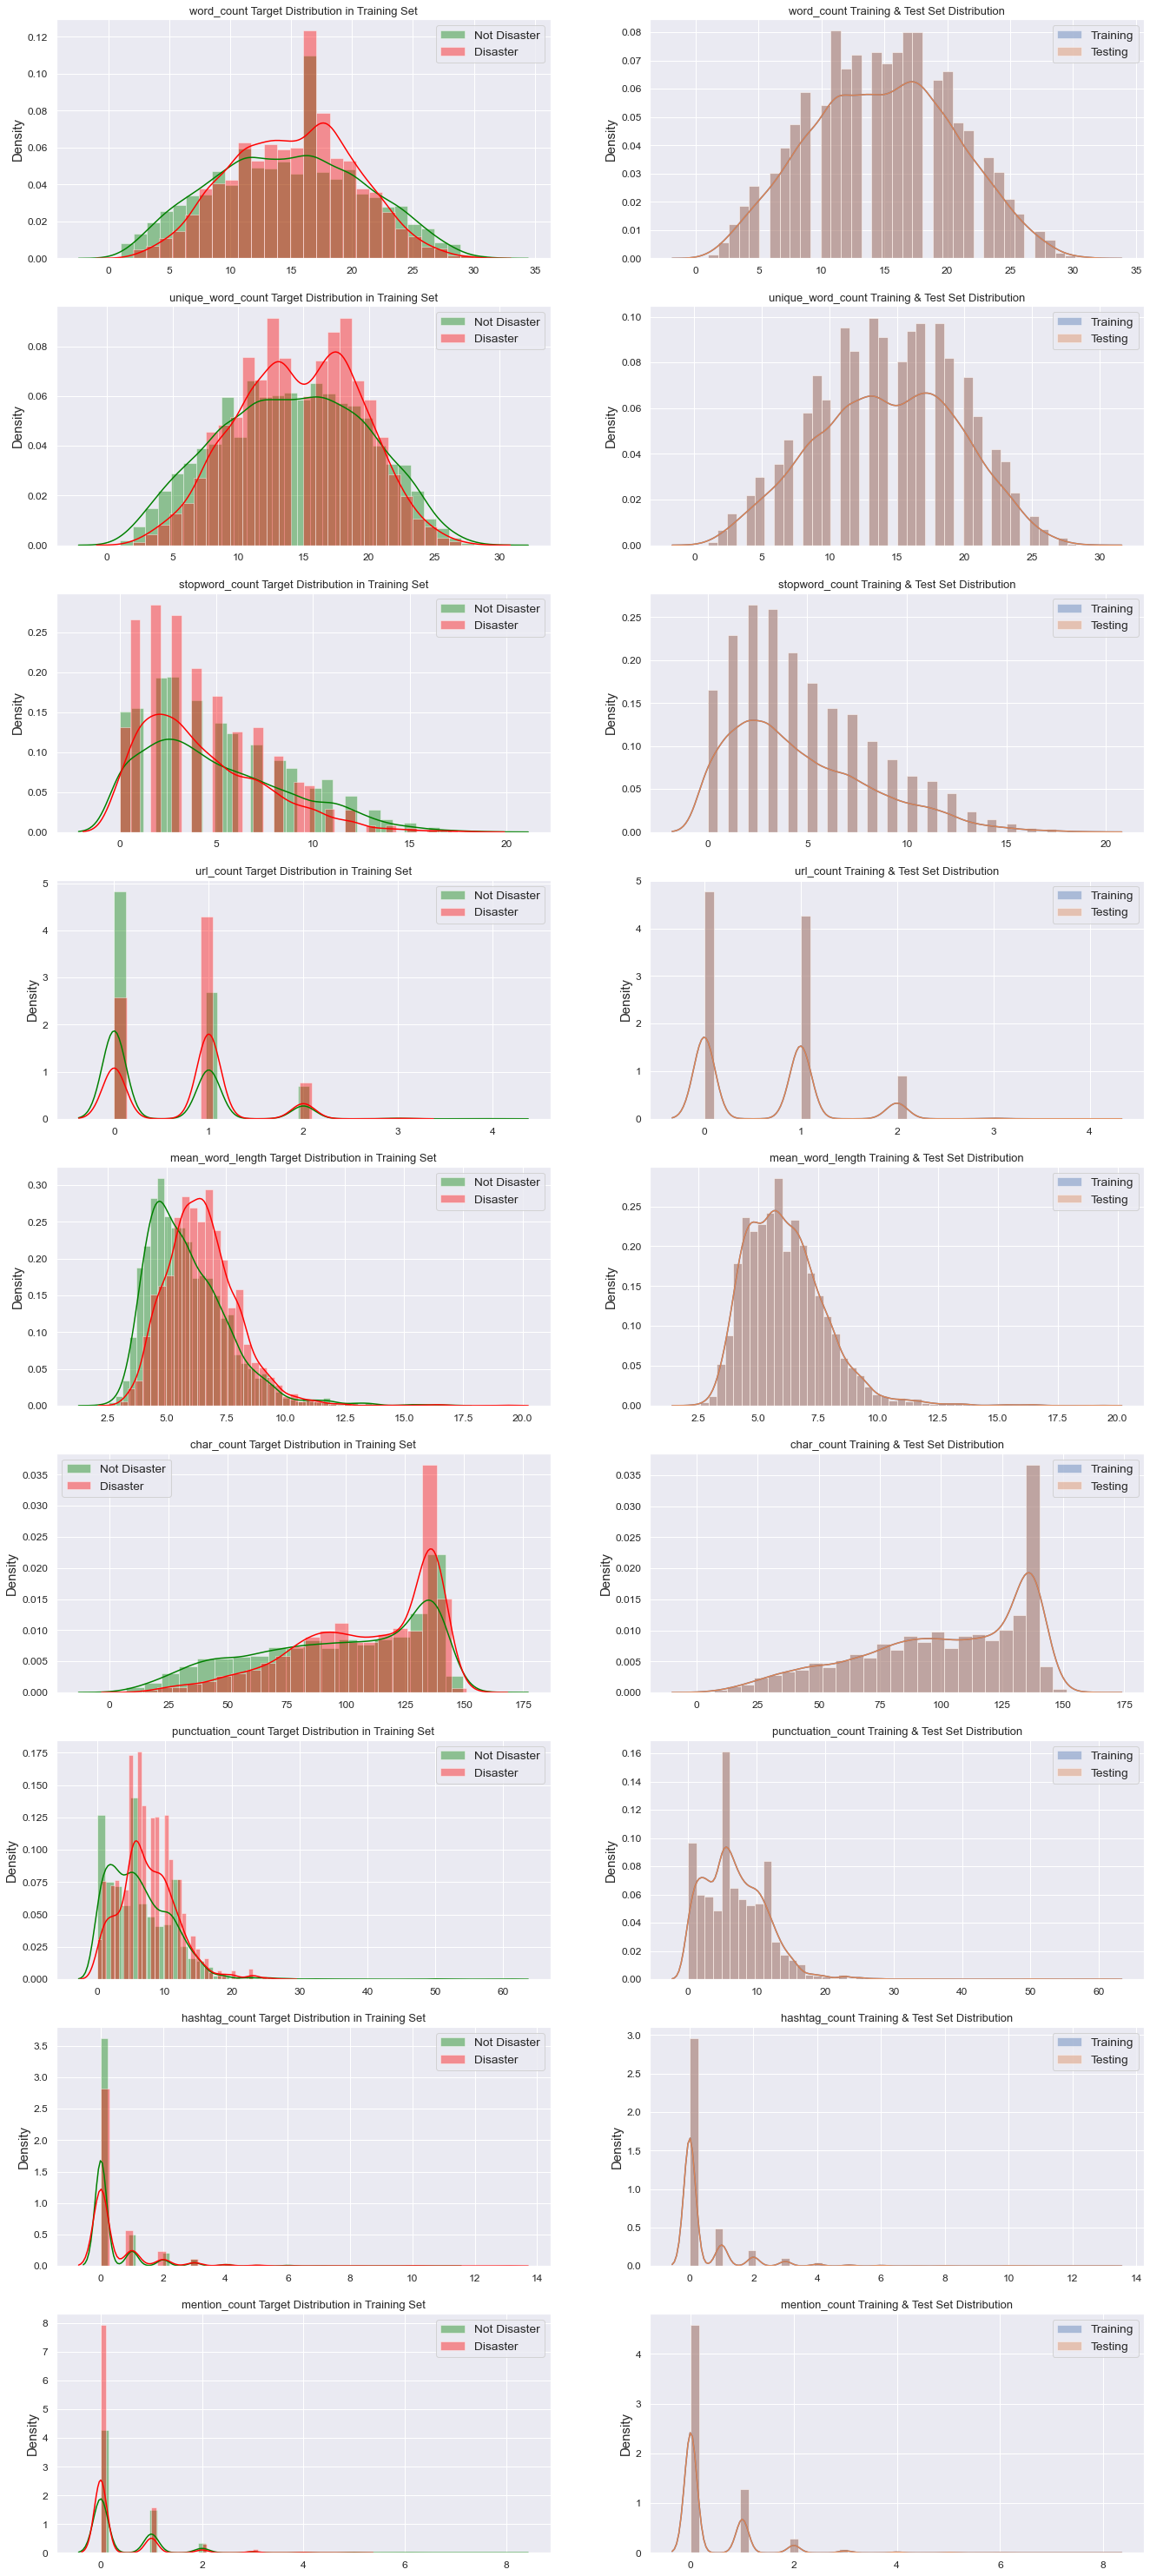

In [16]:
meta_features = ['word_count','unique_word_count','stopword_count','url_count','mean_word_length',
                 'char_count','punctuation_count','hashtag_count','mention_count']

DISASTER_TWEETS= train['target']==1

fig,axes = plt.subplots(ncols=2,nrows=len(meta_features),figsize=(20,50))
for i, feature in enumerate(meta_features):
    sns.distplot(train.loc[~DISASTER_TWEETS][feature],label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train.loc[DISASTER_TWEETS][feature],label='Disaster', ax=axes[i][0],color='red')
    sns.distplot(train[feature],label='Training',ax=axes[i][1])
    sns.distplot(train[feature],label='Testing',ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x',labelsize=12)
        axes[i][j].tick_params(axis='y',labelsize=12)
        axes[i][j].legend()
        
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)


plt.show()

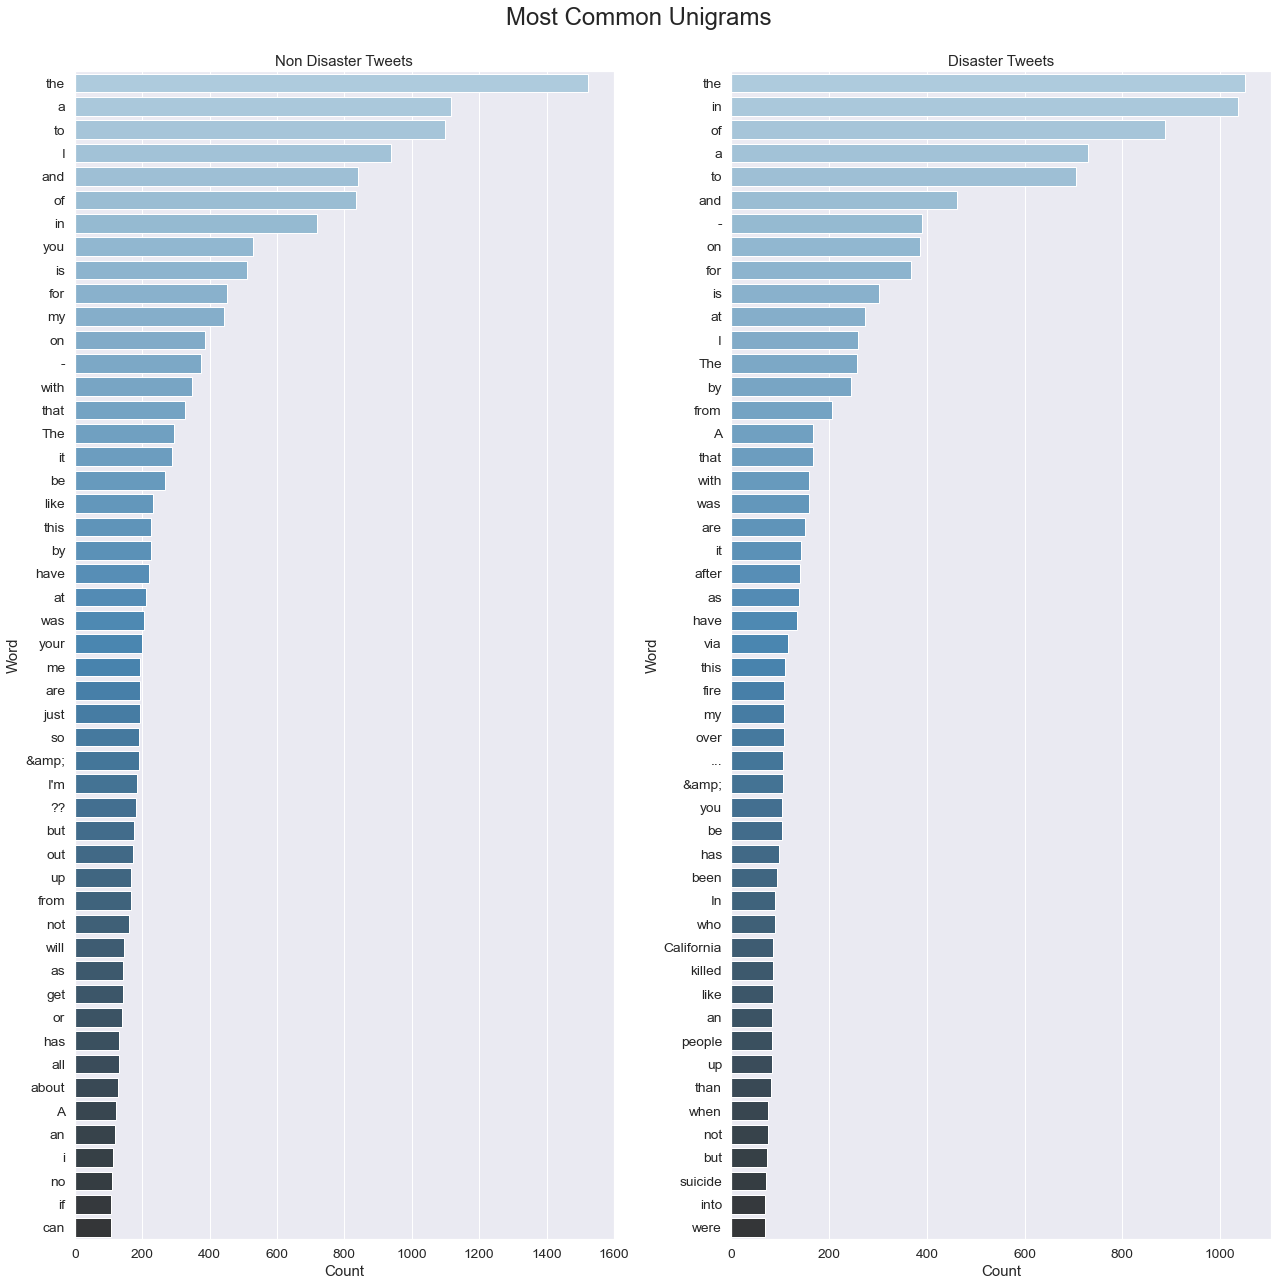

In [17]:
## Most Common words
listt= [ train[train['target'] == 0]['text'], train[train['target'] == 1]['text']]

fig,axes=plt.subplots(ncols=2, nrows=1, figsize=(18,18))
axes=axes.flatten()

for i,j in zip(listt,axes):
    
    new=i.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    
    counter=Counter(corpus)
    most=counter.most_common()
    x,y=[], []
    for word,count in most[:50]:
        x.append(word)
        y.append(count)
        
    sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
    
axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')
fig.suptitle("Most Common Unigrams", fontsize=24, va='baseline')
plt.tight_layout()

# Data Cleaning
Removed urls, emojis, html tags and punctuations,
Tokenized the tweet base texts,
Lower cased clean text,
Removed stopwords,
Applied part of speech tags,
Converted part of speeches to wordnet format,
Applying word lemmatizer,
Converted tokenized text to string again.

In [18]:
def remove_url(text):
    url=re.compile(r'https?://\S+\www\.\S+')
    return  url.sub(r'', text)
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html,'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train['text_clean'] = train['text'].apply(lambda x: remove_url(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))

In [19]:
train['tokenized']=train['text_clean'].apply(word_tokenize)

train['lower']=train['tokenized'].apply(lambda x:[word.lower() for word in x])
train['stopwords_removed']=train['lower'].apply(lambda x: [word for word in x if word not in stop])
train['pos_tags']=train['stopwords_removed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
train['wordnet_pos'] = train['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()

train['lemmatized'] = train['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train['lemmatized'] = train['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train['lemma_str'] = [' '.join(map(str, l)) for l in train['lemmatized']]

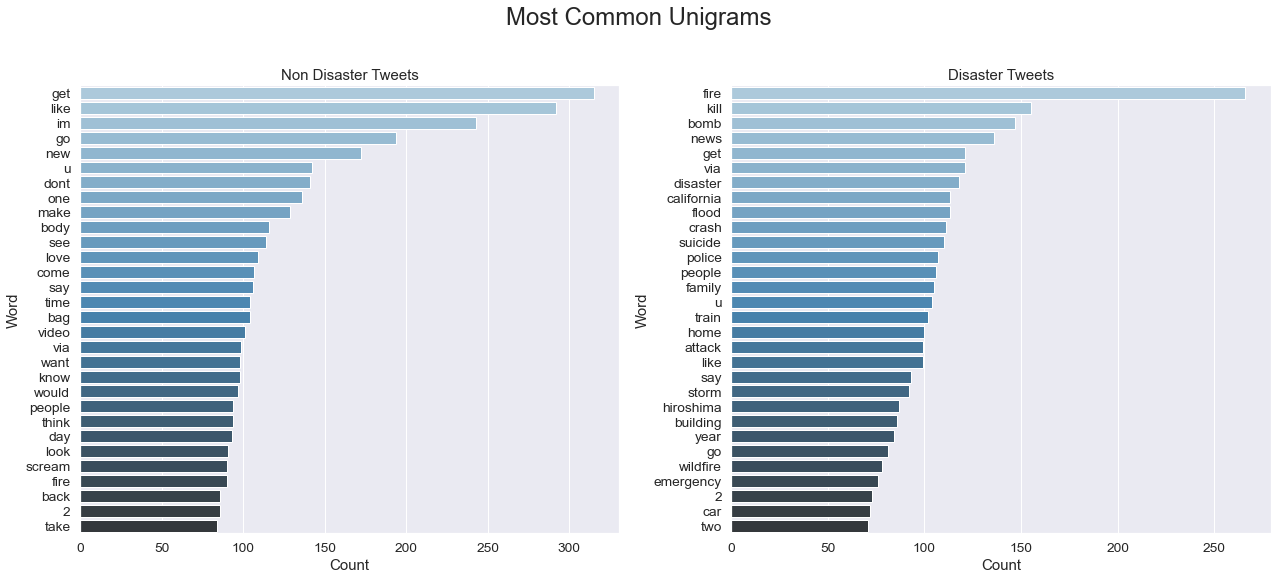

In [20]:
lis = [
    train[train['target'] == 0]['lemma_str'],
    train[train['target'] == 1]['lemma_str']
]
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    
    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y, y=x, palette = 'Blues_d', ax = j)

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [21]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]
        
        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

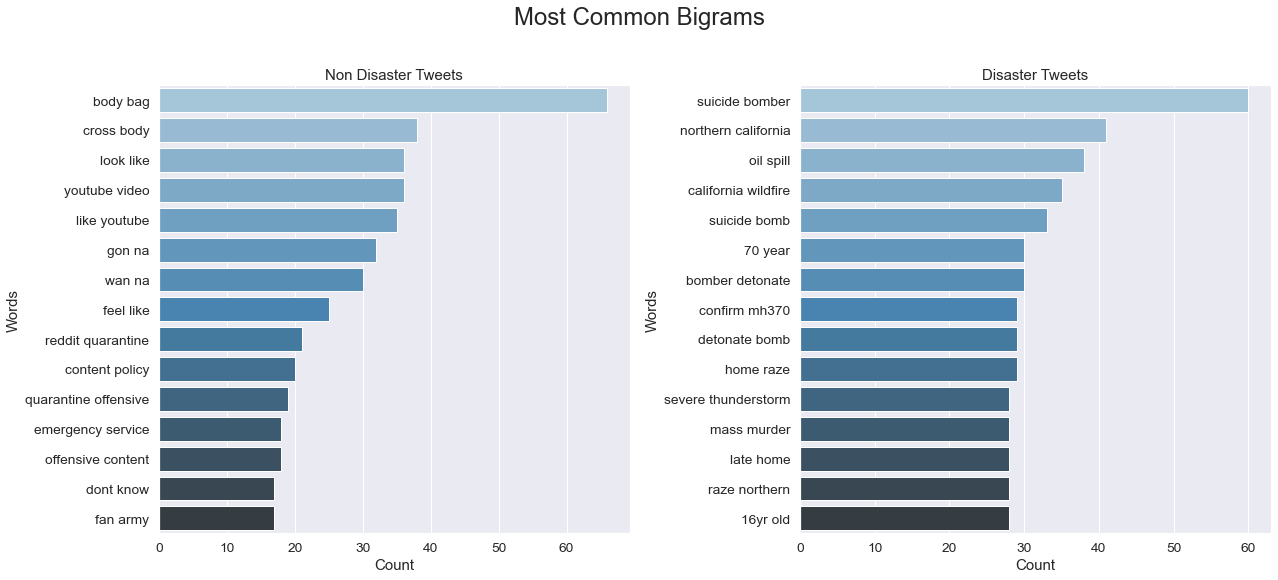

In [22]:
ngrams(2, 'Most Common Bigrams')

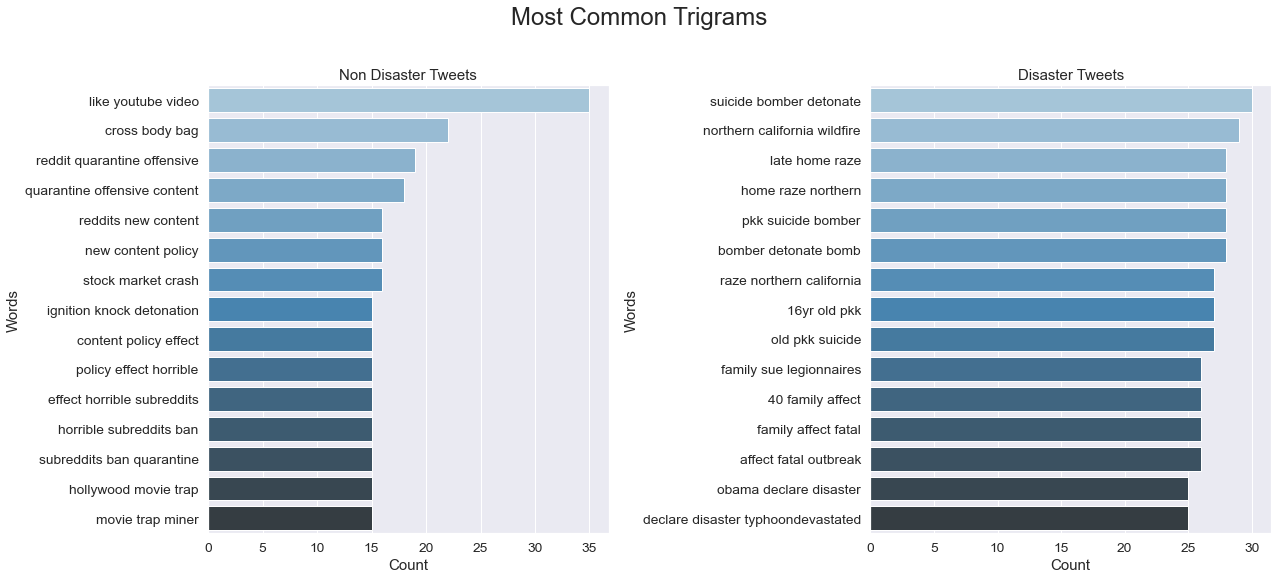

In [23]:
ngrams(3, 'Most Common Trigrams')

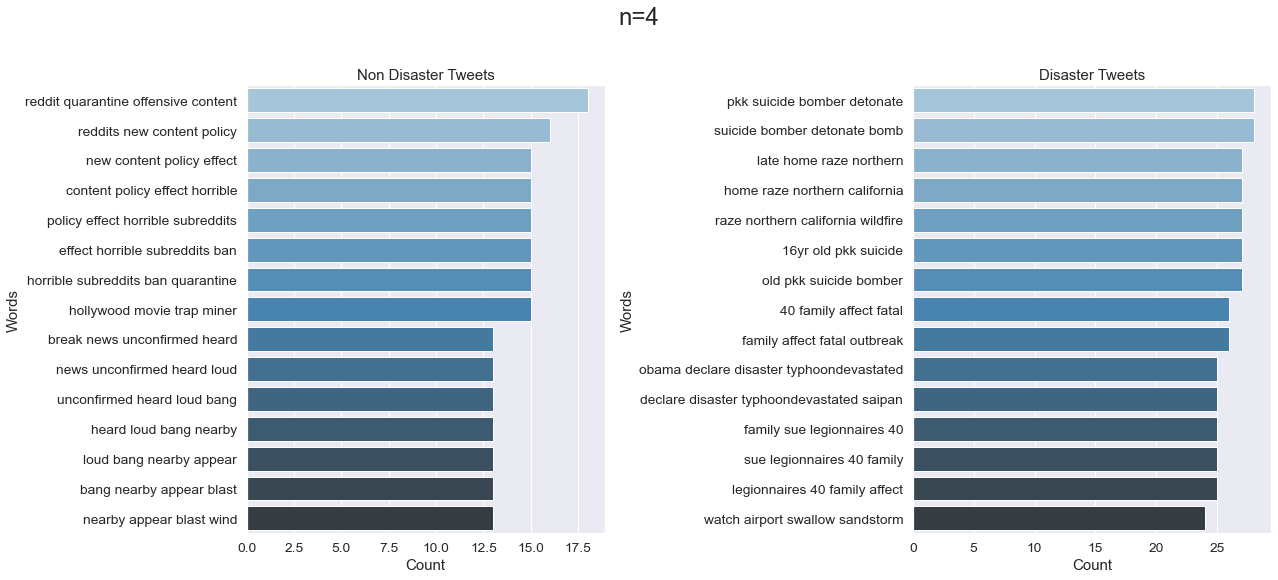

In [24]:
ngrams(4, 'n=4')

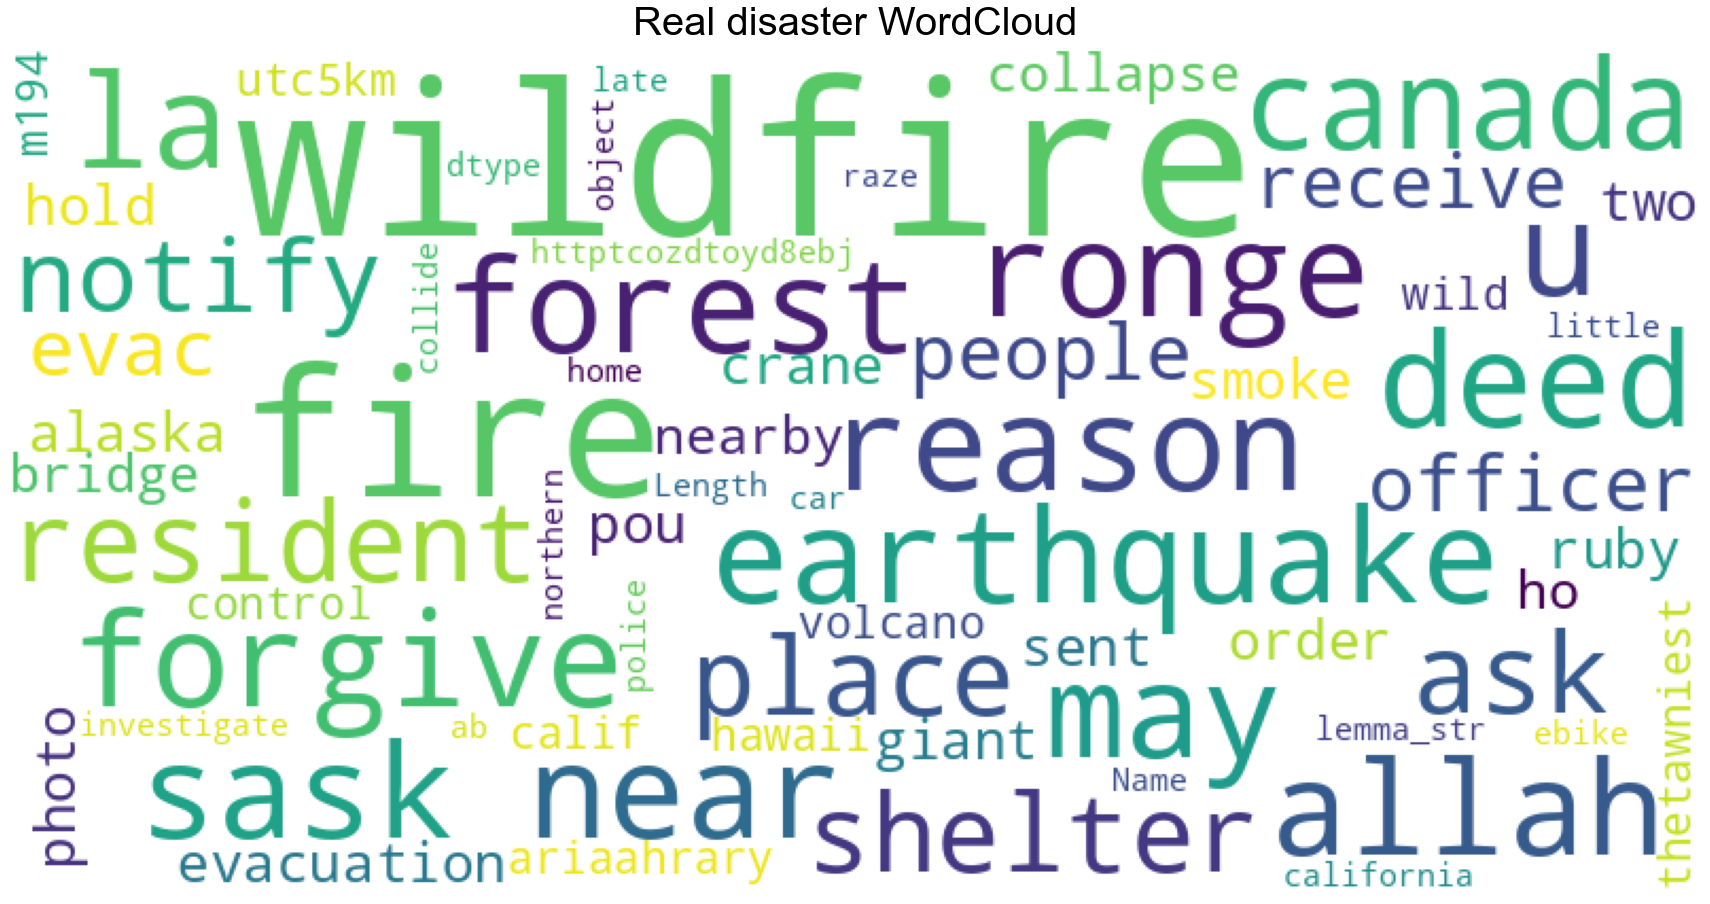

In [25]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1]['lemma_str'], title="Real disaster WordCloud")

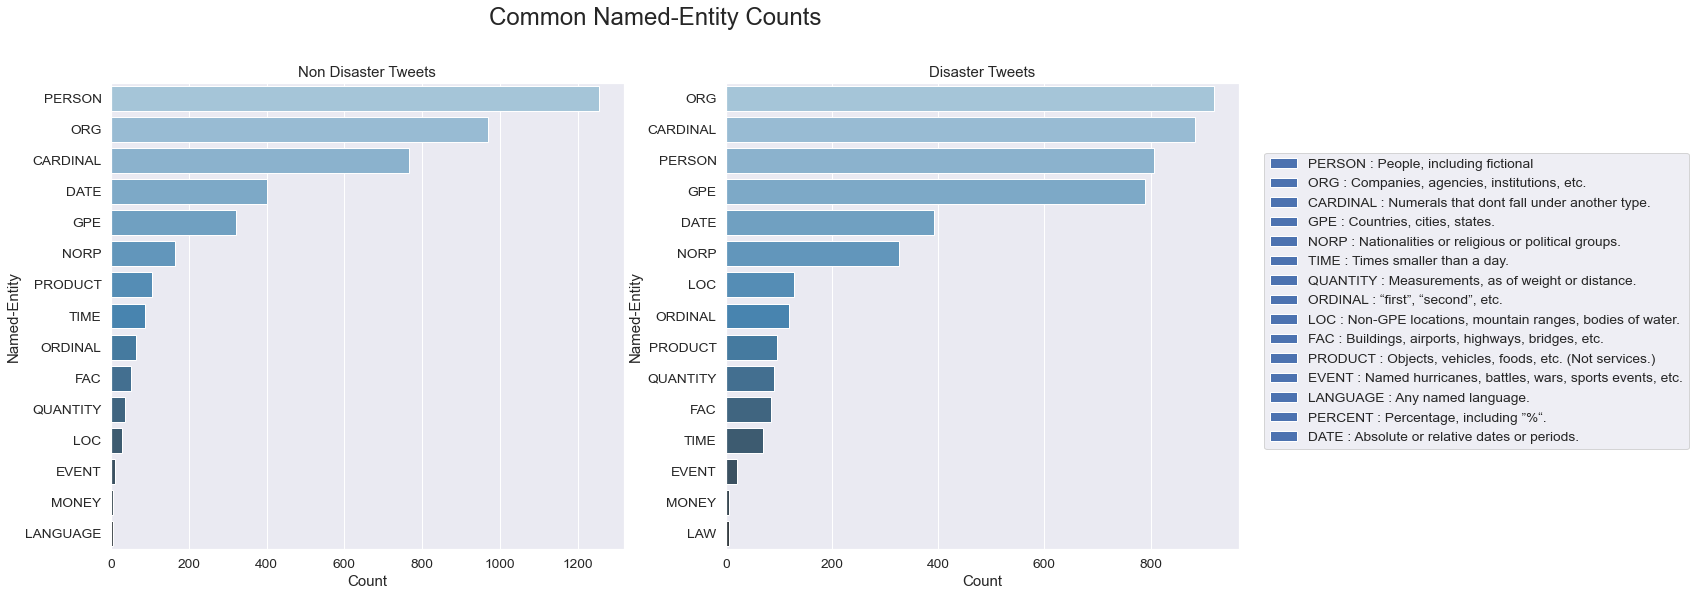

In [26]:
#ner
nlp = spacy.load('en_core_web_sm')

def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)
    
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='Blues_d')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')

patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

In [27]:
!pip install nltk
!pip install spacy==2.3.5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
!pip install pyresparser

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz (12.0 MB)
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=f3d21712a2a78b42be093a480b6c7f1b282364bf6d616892fa1246f1d6df3f93
  Stored in directory: /home/vishu/.cache/pip/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm


In [28]:
!pip install wordcloud